In [1]:
%config IPCompleter.greedy=True

The **objective** of this project is to perform a classification task using machine learning. The classification task consists of classifying news articles into the correct topical category i.e. either **Wellness** or **Home Living8*. The dataset used is a small portion of the larger dataset called "News Category Dataset" collected by author Rishabh Mishra in June 2018. The project is divided into three parts: (i) data understanding, (ii) data preparation & modelling and, (iii) evaluation.

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import pickle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.optimizers import SGD
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import regularizers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

# Understanding and exploring data

## Data understanding and cleaning

<span style="color:red">Step 2</span>

In [4]:
# Step 2

data = pd.read_csv('21201394.csv')

In [5]:
data.head()

,Unnamed: 0,category,headline,authors,link,short_description,date
0,0,HOME & LIVING,Six Expert Tricks For Decorating Small Spaces,NaN,https://www.huffingtonpost.comhttp://www.eliza...,Need a space fix? Don't we all. With most of u...,2013-09-27
1,1,HOME & LIVING,This DIY Tent Is Perfect For Campers Who Don't...,Michelle Manetti,https://www.huffingtonpost.com/entry/diy-tent-...,"See this project featured on 4 Men 1 Lady, and...",2013-07-22
2,2,WELLNESS,The Therapeutic Alliance: The Essential Ingred...,"Deborah L. Cabaniss, MD, Contributor\nProfesso...",https://www.huffingtonpost.com/entry/therapeut...,The anxiety of trying to change something as c...,2012-05-31
3,3,WELLNESS,Where Do You Follow Your Nose?,"Maureen Anderson, Contributor\nMaureen Anderso...",https://www.huffingtonpost.com/entry/life-less...,I hadn't realized how powerful scent was until...,2014-03-31
4,4,WELLNESS,10 Holiday Shopping Guidelines for the Soul,"Dr. Judith Rich, Contributor\nContributor",https://www.huffingtonpost.com/entry/holiday-s...,With a personal history of compulsive holiday ...,2012-11-28


WELLNESS         5985
HOME & LIVING    1995
Name: category, dtype: int64


Text(0, 0.5, 'Count')

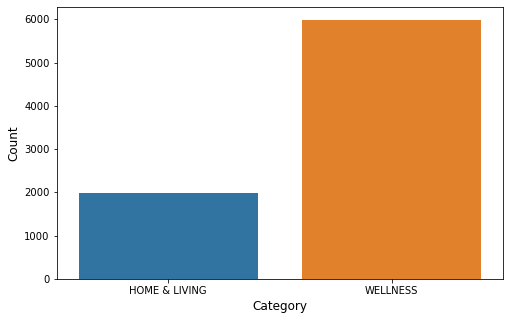

In [6]:
# I can observe the data imbalance using the value_counts func

print(data['category'].value_counts())
plt.figure(figsize=(8,5))
ax = sns.countplot(x="category", data=data)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

In [7]:
# dropping un-nessary columns
# Dropped unnamed: 0 as already index is present
# Dropped link column as had repeated headline information with unique url id's

data.drop(['Unnamed: 0', 'link'], axis=1, inplace=True)

In [8]:
# knowing structure of the data columns

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           7980 non-null   object
 1   headline           7991 non-null   object
 2   authors            5924 non-null   object
 3   short_description  7979 non-null   object
 4   date               7985 non-null   object
dtypes: object(5)
memory usage: 312.6+ KB


In [9]:
# knowing columns

data.columns

Index(['category', 'headline', 'authors', 'short_description', 'date'], dtype='object')

In [10]:
# knowing size of the dataset

data.shape

(8000, 5)

In [11]:
data.isnull().sum()

category               20
headline                9
authors              2076
short_description      21
date                   15
dtype: int64

<span style="color:red">Step 3 (iii)</span>

In [12]:
# Step 3 i, ii are below.
# There are many null records in the data and if I will drop them all then the size of the dataset would be affected badly
# Therefore, according to my observation, I will remove null records based on the potential independent columns only i.e. "headline", "short_description" and based on dependent column i.e. "category"
# dropping null records in the category, headline and short description columns 

data = data.dropna(subset=['category','headline','short_description'])
data.isnull().sum()

category                0
headline                0
authors              2060
short_description       0
date                   15
dtype: int64

In [13]:
# replacing null author names with a blank value

data["authors"].fillna("", inplace = True)


In [14]:
# dropping duplicates record

data = data.drop_duplicates()

In [15]:
# adding CategoryId column for Categories to get it's numerical representation for ML modelling
# Home & Living denoted as 0
# Wellness denoted as 1
# Source: https://www.statology.org/pandas-factorize/

data['CategoryId'] = data['category'].factorize()[0]

In [16]:
#knowing shape after data preparation

data.shape

(7949, 6)

In [17]:
data.head(20)

,category,headline,authors,short_description,date,CategoryId
0,HOME & LIVING,Six Expert Tricks For Decorating Small Spaces,,Need a space fix? Don't we all. With most of u...,2013-09-27,0
1,HOME & LIVING,This DIY Tent Is Perfect For Campers Who Don't...,Michelle Manetti,"See this project featured on 4 Men 1 Lady, and...",2013-07-22,0
2,WELLNESS,The Therapeutic Alliance: The Essential Ingred...,"Deborah L. Cabaniss, MD, Contributor\nProfesso...",The anxiety of trying to change something as c...,2012-05-31,1
3,WELLNESS,Where Do You Follow Your Nose?,"Maureen Anderson, Contributor\nMaureen Anderso...",I hadn't realized how powerful scent was until...,2014-03-31,1
4,WELLNESS,10 Holiday Shopping Guidelines for the Soul,"Dr. Judith Rich, Contributor\nContributor",With a personal history of compulsive holiday ...,2012-11-28,1
5,WELLNESS,Enough Is Enough,"Dr. Michele Nealon, Contributor\nPresident, Th...",We simply cannot continue to cut access to men...,2012-12-20,1
6,WELLNESS,Lights Go On -- Part XII -- The Golden Core,"Thomas Bähler, Contributor\nBest Selling Autho...","Now, standing alone in the middle of this empt...",2013-10-01,1
7,HOME & LIVING,'Up In The Air Somewhere's' Gold Point Vessel ...,"Ecofabulous, Ecofabulous",It's especially handy for those stray paper cl...,2013-04-18,0
8,HOME & LIVING,5 Great Housewarming Gift Ideas,,There were 4.65 million homes bought last year...,2013-08-07,0
9,HOME & LIVING,How to Organize Your Bedside Table for Better ...,"Brooks Palmer, Contributor\nDe-cluttering expert",Our well-being is dependent on how well we res...,2013-01-23,0


## Data exploration

### Create and Fit Bag of Words Model to find most common words

<span style="color:red">Step 3 (i)</span>

In [18]:

# Finding words more common for each category using countvectorizer
vectorizer = CountVectorizer(stop_words='english')

# Week D10W1 (combination of all steps in a function)
def countVectorize(desc):
    description = vectorizer.fit_transform(desc)
    tokens_and_counts = zip(vectorizer.get_feature_names_out(), np.asarray(description.sum(axis=0)).ravel())
    df_tokens = pd.DataFrame(tokens_and_counts, columns=['Token', 'Count'])
    df_tokens.sort_values("Count", ascending=False, inplace=True)
    df_tokens.reset_index(inplace=True, drop=True)
    #Most Popular Tokens
    most_popular_tokens = df_tokens.nlargest(columns="Count", n=20)
    return most_popular_tokens


<span style="color:red">Step3 (ii) Column Selection</span>

In [19]:
# Reason:
# I think both the "headline" and "short description" columns contain important information to predict the correct topical category of the text.
# Therefore, combining them and storing them as a new column "description" to perform necessary NLP pre-processing on one column only.
# Also,
# I didn't include "authors" column as the same author can publish articles for both the categories and if I will perform tokenization on author name then many authors have same first names which will lead to incorrect analysis of categories.
# And didn't include "date" column as I cannot see a useful pattern in dates of publishing.

data["description"]=data["headline"]+" "+data["short_description"]
wellness=data[data["category"]=="WELLNESS"]["description"]
living=data[data["category"]=="HOME & LIVING"]["description"]

#Mean sentence length for both the categories
mean_len_wellness = wellness.str.len().mean()
mean_len_living = living.str.len().mean()

print("Mean sentence length: Wellness -> ",mean_len_wellness)
print("Mean sentence length: Home & Living -> ", mean_len_living)
print("WELLNESS > HOME & LIVING")

Mean sentence length: Wellness ->  225.66476701307408
Mean sentence length: Home & Living ->  171.89813414019162
WELLNESS > HOME & LIVING


### Creating wordcloud representation

In [20]:
# Source: https://re-thought.com/creating-wordclouds-in-python/

def make_wordcloud(text):
    wordcloud = WordCloud(width=600, height=600).generate(text)
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

###  Most popular keywords in wellness category

Most popular keywords in wellness category:
       Token  Count
0      life    870
1    health    795
2    people    684
3      time    654
4       new    594
5     study    573
6      make    465
7      like    444
8       day    439
9    cancer    437
10    sleep    433
11     love    426
12     just    421
13   weight    380
14  healthy    377
15      don    365
16     need    359
17      way    356
18     help    350
19     know    343
---------------------------------------------
Wellness Top Wordcloud:


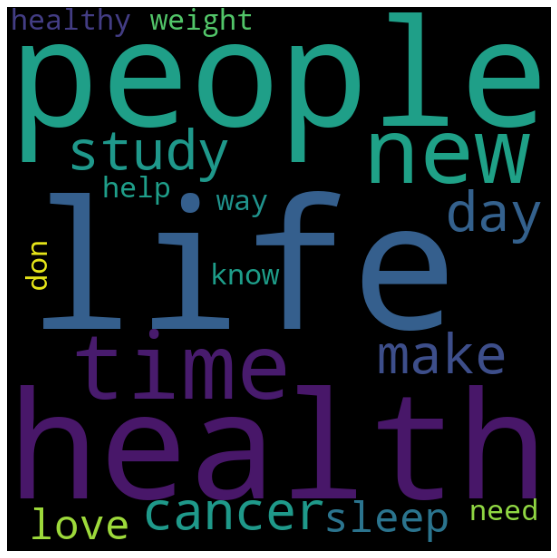

In [21]:
print("Most popular keywords in wellness category:\n",countVectorize(wellness))
df_new=countVectorize(wellness).to_csv('wellness_df',header=None)
df_wellness=pd.read_csv('wellness_df')
print("---------------------------------------------\nWellness Top Wordcloud:")
make_wordcloud(str(df_wellness))

###  Most popular keywords in home and living category

Most popular keywords in home and living category:
      Token  Count
0     home    806
1   photos    691
2      day    219
3     make    208
4    ideas    200
5    house    196
6    video    195
7      new    193
8     time    143
9     just    137
10    like    134
11     diy    133
12   craft    129
13   photo    125
14  design    115
15   check    114
16    room    113
17      ll    109
18      10    108
19    tips    106
------------------------------------------------
Home & Living Top Wordcloud:


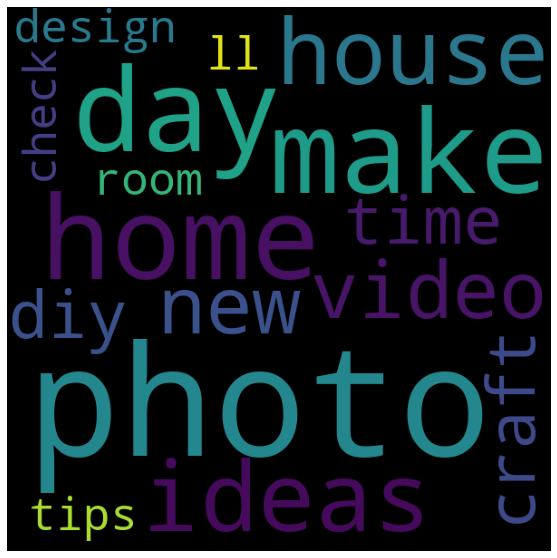

In [22]:
print("Most popular keywords in home and living category:\n",countVectorize(living))
hliving_top_words=countVectorize(living).to_csv('df_hliving',header=None)
df_hliving=pd.read_csv('df_hliving')
print("------------------------------------------------\nHome & Living Top Wordcloud:")
make_wordcloud(str(df_hliving))

# Data Preparation 

### Declared Dependent and Independent Value

<span style="color:red">Step 4</span>

In [23]:

# X is the independent variable
# y is the dependent variable
X = data.loc[:,"description"]
y = data.loc[:,"CategoryId"]


### Split the dataset into train, valid, test 

In [24]:
# I am dividing the dataset on the best approach suggested generally i.e. training = 70%, vaild = 15%, test = 15% of dataset as it's not a very large dataset.
# Source: https://www.v7labs.com/blog/train-validation-test-set
# In this step, I will first split the dataset into train_plus_valid and test dataset.
# Then split train_plus_valid into train dataset and valid dataset.

X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, y, random_state=0, test_size = 0.15, train_size = 0.85)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.15/0.85, train_size = 0.7/0.85)

In [25]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(5563,)
(1193,)
(1193,)


### Concatenating and saving csv files for train, validation, test dataset

In [26]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data

,description,CategoryId
3961,"Despite New Study, Experts Still Warn Of Link ...",1
411,Weekly Roundup Of EBay Vintage Home Finds (PHO...,0
2759,Boston Named the Healthiest City in America Fo...,1
1198,"After An Eye-Opening Shopping Experience, Alys...",1
842,A Look Inside 10 Fantastic First Homes House T...,0
...,...,...
2153,The Protagonist When you are a supporting char...,1
3070,Ziggy Marley Says 'Love Can Never Have A Negat...,1
3106,12 Surprising Facts About Pet Rats Contrary to...,1
1293,Make a Lamp Using Old Toys If your kid tends t...,0


In [27]:
train_data=train_data.to_csv('train.csv')

In [28]:
valid_data = pd.concat([X_valid,y_valid], axis=1)
valid_data=valid_data.to_csv('valid.csv')

In [29]:
test_data=pd.concat([X_test,y_test], axis=1)
test_data=test_data.to_csv('test.csv')

### Pre-processing steps
Our data is text input so to extract meaningful results we need to perform some necessary pre-processing. As better quality of data will generate better results from models. 
 - Removing digits: When I searched the top words in each category, I found some numbers in it which is not                meaningful in predicting or differentiating the categories.
 - Removing tags: not useful
 - Removing special characters: not useful
 - Lowercasing text: helps with the consistency of expected output
 - Removing stopwords: do not provide meaningful information
 - Lemmatization: helps in grouping together the different inflected forms of a word. For e.g. "health" and "healthy"          to "health"

In [30]:
# Source: https://www.studytonight.com/python-howtos/remove-numbers-from-string-in-python

def remove_digits(text):
    text = re.sub(r'[0-9]','',text)
    return text


In [31]:
# Source: https://www.analyticsvidhya.com/blog/2021/12/text-classification-of-news-articles/

def remove_tags(text):    
    remove = re.compile(r'')
    text= re.sub(remove, '', text)
    text = re.sub(r'[^\w\s]','',text)
    return text

def special_char(text):
    reviews = ''
    for x in text:
        if x.isalnum():
            reviews = reviews + x
        else:
            reviews = reviews + ' '
    return reviews

def convert_lower(text):
    return text.lower()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]

def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

### Loading train dataset to perform pre-processing steps on text 

<span style="color:red">Step 5</span>

In [32]:
# The reason and choices for performing the pre-processing on data is mentioned above.

train_data=pd.read_csv('train.csv')

In [33]:
train_data

,Unnamed: 0,description,CategoryId
0,3961,"Despite New Study, Experts Still Warn Of Link ...",1
1,411,Weekly Roundup Of EBay Vintage Home Finds (PHO...,0
2,2759,Boston Named the Healthiest City in America Fo...,1
3,1198,"After An Eye-Opening Shopping Experience, Alys...",1
4,842,A Look Inside 10 Fantastic First Homes House T...,0
...,...,...,...
5558,2153,The Protagonist When you are a supporting char...,1
5559,3070,Ziggy Marley Says 'Love Can Never Have A Negat...,1
5560,3106,12 Surprising Facts About Pet Rats Contrary to...,1
5561,1293,Make a Lamp Using Old Toys If your kid tends t...,0


In [34]:
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [35]:
train_data['description'] = train_data['description'].apply(remove_digits)
train_data['description'] = train_data['description'].apply(remove_tags)
train_data['description'] = train_data['description'].apply(special_char)
train_data['description'] = train_data['description'].apply(convert_lower)
train_data['description'] = train_data['description'].apply(remove_stopwords)
train_data['description'] = train_data['description'].apply(lemmatize_word)
train_data

,description,CategoryId
0,despite new study expert still warn link footb...,1
1,weekly roundup ebay vintage home find photo al...,0
2,boston named healthiest city america follow ne...,1
3,eyeopening shopping experience alyssa croteau ...,1
4,look inside fantastic first home house tour ro...,0
...,...,...
5558,protagonist supporting character life let othe...,1
5559,ziggy marley say love never negative effect po...,1
5560,surprising fact pet rat contrary many people b...,1
5561,make lamp using old toy kid tends get attached...,0


### Loading evaluation dataset to perform pre-processing steps on text 

<span style="color:red">Step 5</span>

In [36]:
# The reason and choices for performing the pre-processing on data is mentioned above.

valid_data=pd.read_csv('valid.csv')

In [37]:
valid_data

,Unnamed: 0,description,CategoryId
0,6480,Desire/Acquire: Nautical Needlepoint We're suc...,0
1,930,Astrology Now: Thursday's New Moon Signals New...,1
2,3282,7 Signs of Emotional Wellness When I meet new ...,1
3,1128,Yoga and Qigong: Two Streams From a Single Sou...,1
4,1664,"Controlling Blood Pressure, Cholesterol Could ...",1
...,...,...,...
1188,3723,Low-Calorie French Fries Recipe What if I told...,1
1189,4219,How to Make the Most of Your Life Transitions ...,1
1190,2979,Author Nicholas Sparks On The Key To Happiness...,1
1191,885,"All Of These Homes Are $100,000 Or Less (PHOTO...",0


In [38]:
valid_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [39]:
valid_data['description'] = valid_data['description'].apply(remove_digits)
valid_data['description'] = valid_data['description'].apply(remove_tags)
valid_data['description'] = valid_data['description'].apply(special_char)
valid_data['description'] = valid_data['description'].apply(convert_lower)
valid_data['description'] = valid_data['description'].apply(remove_stopwords)
valid_data['description'] = valid_data['description'].apply(lemmatize_word)
valid_data

,description,CategoryId
0,desireacquire nautical needlepoint sucker jona...,0
1,astrology thursday new moon signal new beginni...,1
2,sign emotional wellness meet new people social...,1
3,yoga qigong two stream single source origin yo...,1
4,controlling blood pressure cholesterol could h...,1
...,...,...
1188,lowcalorie french fry recipe told could make h...,1
1189,make life transition transition wonderful oppo...,1
1190,author nicholas spark key happiness video matt...,1
1191,home le photo bring good news bargainhunting f...,0


### Finding more common words for each target variable in training set

In [40]:
# to take a look at most common words after pre-processing

print("Trainset - Home & Living popular keywords:")
countVectorize(train_data[train_data['CategoryId']==0]['description'])

Trainset - Home & Living popular keywords:


,Token,Count
0,home,598
1,photo,563
2,idea,191
3,day,182
4,make,157
5,house,146
6,video,142
7,way,131
8,new,121
9,tip,120


In [41]:
print("Trainset - Wellness popular keywords:")
countVectorize(train_data[train_data['CategoryId']==1]['description'])

Trainset - Wellness popular keywords:


,Token,Count
0,life,700
1,health,542
2,time,498
3,study,469
4,people,465
5,way,451
6,make,406
7,new,402
8,day,398
9,year,344


### Create and Fit Bag of Words Model using Tf-idf Vectorizer
As the machine learning models work on numerically represented data therefore we need the vectorizer.
- I chose TF-IDF vectorizer because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. Also, this technique is good for text classification or for helping a machine read words in numbers.
- I didn't add max_features parameter to it because if I will reduce the value of max_features, there is a high chance that the majority of words chosen will be from the majority class (Wellness). This makes sense since TF-IDF is selecting features based on term frequency alone and (Wellness) records are in majority.  
    
    Source: https://www.analyticsvidhya.com/blog/2021/09/creating-a-movie-reviews-classifier-using-tf-idf-in-python/

In [42]:
# Feature Engineering
vectorizer = TfidfVectorizer()

# Vectorizing training and validation dataset
# Fit the vectorizer on training dataset
vectorizer.fit(train_data['description'])

# Transforming training and validation dataset
X_train_matrix = vectorizer.transform(train_data['description'])
X_valid_matrix = vectorizer.transform(valid_data['description'])


In [43]:
# checking size of train data matrix generated

X_train_matrix.shape

(5563, 14814)

In [44]:
# checking size of valid data matrix generated

X_valid_matrix.shape

(1193, 14814)

# Data Modelling

## Here are my chosen binary classifiers:
1. Support Vector Classifier (SVC): As regarded as one of the best text classification algorithm according to the below sources and is best when the number of features are high as compared to a number of data points in the dataset. Also, it's faster, takes less memory and works good on small datasets.


2. Logistic Regression: Again regarded as one of the best binary classifier. In chapter 5: Logistic Regression of "Speech and Language Processing" by Daniel Jurafsky & James H. Martin. It is mentioned that in the NLP world, it’s generally accepted that Logistic Regression is a great starter algorithm for text related classification.

Therefore, I chose to study both these classfiers on my dataset.

Approach: Logistic Regression (LR) is a probabilistic classification model using the sigmoid function, whereas Support Vector Classifiers (SVC) are a more geometric approach that maximise the margins to each class. They are similar in that they both can divide the feature space with a decision boundary.

Source: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568#:~:text=Linear%20Support%20Vector%20Machine%20is,the%20best%20text%20classification%20algorithms.

Source 2: https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16#:~:text=SVM%20tries%20to%20finds%20the,are%20near%20the%20optimal%20point.

<span style="color:red">Step 6</span>

## Fitting the model

### SVC
#### Parameters:
1. **Linear** kernel is the most basic type of kernel, one dimensional in nature. It proves to be the best function when there are lots of features. The linear kernel is mostly preferred for text-classification problems as most of these kinds of classification problems can be linearly separated.
2. Regularization parameter, **C** must be strictly positive, default = 1.0
3. **Random_State** is set to **0** to get the reproducible results.

In [45]:
svc_model = SVC(kernel="linear", C=1.0, random_state=0)
svc_model.fit(X_train_matrix, y_train)

SVC(kernel='linear', random_state=0)

### Logistic Regression

#### Parameters:
1. I used **Liblinear** solver because it performs faster and better for data with high dimensionality. Also, it was the default historical approach to work with small datasets. Also, according to the following source, liblinear solver gave better accuracy.
       Source: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

2. **Random_State** is set to **0** to get the reproducible results.

In [46]:
l_reg = LogisticRegression(solver='liblinear', random_state=0)
l_reg.fit(X_train_matrix,y_train)

LogisticRegression(random_state=0, solver='liblinear')

<span style="color:red">Step 7</span>

## Deep Learning model: CNN


### Splitting the data into train, validation and test sets

In [47]:
# The split is according to standards mentioned above: Train: 70%, Validation: 15%, Test: 15%

X_train_plus_valid_1, X_test_1, y_train_plus_valid_1, y_test_1 = train_test_split(X, y, random_state=0, test_size = 0.15, train_size = 0.85)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_plus_valid_1, y_train_plus_valid_1, random_state=0, test_size = 0.15/0.85, train_size = 0.7/0.85)

In [48]:
# Printing their shapes

print(X_train_1.shape)
print(X_valid_1.shape)
print(X_test_1.shape)

(5563,)
(1193,)
(1193,)


In [49]:
# Concatenating x and y into respective datasets.

train_data_1 = pd.concat([X_train_1,y_train_1], axis=1)
valid_data_1 = pd.concat([X_valid_1,y_valid_1], axis=1)
test_data_1 = pd.concat([X_test_1,y_test_1], axis=1)

### Pre-processing on X train, validation and test dataset

In [50]:
# Performing above mentioned pre-processing tasks on train data

train_data_1['description'] = train_data_1['description'].apply(remove_digits)
train_data_1['description'] = train_data_1['description'].apply(remove_tags)
train_data_1['description'] = train_data_1['description'].apply(special_char)
train_data_1['description'] = train_data_1['description'].apply(convert_lower)
train_data_1['description'] = train_data_1['description'].apply(remove_stopwords)
train_data_1['description'] = train_data_1['description'].apply(lemmatize_word)
train_data_1

,description,CategoryId
3961,despite new study expert still warn link footb...,1
411,weekly roundup ebay vintage home find photo al...,0
2759,boston named healthiest city america follow ne...,1
1198,eyeopening shopping experience alyssa croteau ...,1
842,look inside fantastic first home house tour ro...,0
...,...,...
2153,protagonist supporting character life let othe...,1
3070,ziggy marley say love never negative effect po...,1
3106,surprising fact pet rat contrary many people b...,1
1293,make lamp using old toy kid tends get attached...,0


In [51]:
# Performing above mentioned pre-processing tasks on validation data

valid_data_1['description'] = valid_data_1['description'].apply(remove_digits)
valid_data_1['description'] = valid_data_1['description'].apply(remove_tags)
valid_data_1['description'] = valid_data_1['description'].apply(special_char)
valid_data_1['description'] = valid_data_1['description'].apply(convert_lower)
valid_data_1['description'] = valid_data_1['description'].apply(remove_stopwords)
valid_data_1['description'] = valid_data_1['description'].apply(lemmatize_word)
valid_data_1

,description,CategoryId
6480,desireacquire nautical needlepoint sucker jona...,0
930,astrology thursday new moon signal new beginni...,1
3282,sign emotional wellness meet new people social...,1
1128,yoga qigong two stream single source origin yo...,1
1664,controlling blood pressure cholesterol could h...,1
...,...,...
3723,lowcalorie french fry recipe told could make h...,1
4219,make life transition transition wonderful oppo...,1
2979,author nicholas spark key happiness video matt...,1
885,home le photo bring good news bargainhunting f...,0


In [52]:
# Performing above mentioned pre-processing tasks on test data

test_data_1['description'] = test_data_1['description'].apply(remove_digits)
test_data_1['description'] = test_data_1['description'].apply(remove_tags)
test_data_1['description'] = test_data_1['description'].apply(special_char)
test_data_1['description'] = test_data_1['description'].apply(convert_lower)
test_data_1['description'] = test_data_1['description'].apply(remove_stopwords)
test_data_1['description'] = test_data_1['description'].apply(lemmatize_word)
test_data_1

,description,CategoryId
3429,merriest city america youll want party holiday...,0
1468,invisible garden house allows enjoy outdoors m...,0
168,rethinking intelligence could learn think ahea...,1
1757,bored weight gain boredom often give u pause b...,1
5713,greater gift recognition breast cancer click s...,1
...,...,...
1451,life loud conquering fear high sea first heard...,1
125,alchemist conversation phil stutz part ii phil...,1
4094,pope political philosopher time everpresent fi...,0
6764,houzzs real cost finder help figure much renov...,0


### Preparing word embedding for the deep learning model

In [53]:
# Tokenizer allows to vectorize a text corpus, by turning each text into either a sequence of integers(like index of token in a dict.) or into a vector where the coeficient of each token could be binary, based on word count, based on tf-idf
# Using keras tokenizer to build word embeddings and sequence preprocessing
# I am considering top 10,000 frequent words for tokenization and discard rare words

tokenizer = Tokenizer(num_words=10000)

# Fitting tokenizer on X_train data
tokenizer.fit_on_texts(X_train_1.tolist())

print(str(tokenizer.texts_to_sequences(["home is beautiful"])))

# The output depicts that most common words do not have a large index in our embedding space.
# Those whose occurrence is moderate will be given a moderate index value. Also, 0 value is reserved and won’t be provided to any text.


[[40, 8, 467]]


In [54]:
# Converting all the X, y data columns to list type for processing

X_train_1=X_train_1.tolist()
y_train_1=y_train_1.tolist()
X_valid_1=X_valid_1.tolist()
y_valid_1=y_valid_1.tolist()
X_test_1=X_test_1.tolist()
y_test_1=y_test_1.tolist()

In [55]:
# Converting words in the description to numercial sequences and storing them as arrays

x_train=np.array(tokenizer.texts_to_sequences(X_train_1))
x_valid=np.array(tokenizer.texts_to_sequences(X_valid_1))
x_test=np.array(tokenizer.texts_to_sequences(X_test_1))

C:\Users\user\AppData\Local\Temp/ipykernel_36000/2230030543.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train=np.array(tokenizer.texts_to_sequences(X_train_1))
C:\Users\user\AppData\Local\Temp/ipykernel_36000/2230030543.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid=np.array(tokenizer.texts_to_sequences(X_valid_1))
C:\Users\user\AppData\Local\Temp/ipykernel_36000/2230030543.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different le

In [56]:
# One problem is that in each sequence is the different length of words, and to specify the length of word sequence,
# we need to provide a maxlen parameter and to solve this, we need to use pad_sequence(),
# which simply pads the sequence of words with zeros. I am using maxlen=100 as after pre-processing as meaningful length of text is not more than 100.

maxlen = 100
Xcnn_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
Xcnn_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(x_test, padding='post',maxlen=maxlen)

In [57]:
print(Xcnn_train[0])

[ 966   47   63  572  209 8951    5 1255  236 3117    3 1371  168    4
   47   63  420    9 3117   71   29   17   25 1208   10  204   43   25
  278  250  420   28  572   16   29    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [58]:
# Treating the label columns for train, validation and test data
# Converting then into categorical format as I am using loss metric as categorical_crossentropy later. Then storing them as arrays.

train_labels=np.asarray(keras.utils.to_categorical(y_train_1))
valid_labels=np.asarray(keras.utils.to_categorical(y_valid_1))
test_labels=np.asarray(keras.utils.to_categorical(y_test_1))
train_labels[0]

array([0., 1.], dtype=float32)

In [59]:
# Storing processed train and validation data as tensor slices so that it can be used while fitting the model. It will help in word masking when training the model.

train_ds=tf.data.Dataset.from_tensor_slices((Xcnn_train,train_labels))
valid_ds=tf.data.Dataset.from_tensor_slices((Xcnn_valid,valid_labels))

## Deep learning: Building the CNN model

Parameters
- vocab_size: The vocab_size is the same as number of maximum features (10,000) I am considering. Also, the extremely uncommon words will get a higher index value which will be word count (10,000) + 1 because they hold some information.
- embedding_dim: for each input word index present, the model will create a 64-bit embedding
- input_length: max_length of sequence of sentence as mentioned above
- embedding_regularizers.l2, bias_regularizers, kernel_regularizers: to reduce bias as unbalanced data
- Conv1D layer: 128 filters, kernel size=3 (i.e. for each iteration it will look at 3 words at a time), activation function Relu chosen for hidden layers as standard as it works faster as well as output good results.
- GlobalMaxPooling1D layer: Considers the maximum value out of all the word vectors so discards less weighted vectors.
- Last dense layer: Output 2 values as binary classification and to match the labels format, activation function Sigmoid used for binary classification

In [60]:
# Source Code: https://github.com/rsreetech/TextClassificationTensorFlowCNN/blob/master/TensorFlowTweetTextClassificationV1.ipynb


vocab_size=10000  
embedding_dim = 64

# I am using the Sequential model A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Source :https://www.tensorflow.org/guide/keras/sequential_model
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, embeddings_regularizer=regularizers.l2(0.0005)))
textcnnmodel.add(layers.Conv1D(128, 3, activation='relu',kernel_regularizer=regularizers.l2(0.0005),bias_regularizer=regularizers.l2(0.0005)))

# This is followed by a pooling layer that reduces the output of the convolutional layer by half.
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))

# Dropout layers are important in training CNNs because they prevent overfitting on the training data.
textcnnmodel.add(layers.Dropout(0.5))

# The output layer uses a sigmoid activation function to output a value between 0 and 1 for the "Home & Living" and "Wellness" category.
textcnnmodel.add(layers.Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))

# Choice of optimizer: Stochastic Gradient Descent (SGD) seems to take advantage of its learning rate and momentum between each batch to optimize the model’s weights based on the information of the loss function in my case is 'categorical_crossentropy'.
# I set learning rate=0.1, as per the source - Source: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
opt = SGD(lr = 0.1)

# We use a binary cross entropy loss function because the problem we are learning is a binary classification problem. 
textcnnmodel.compile(optimizer = opt,
               loss = 'binary_crossentropy',
               metrics = ['accuracy','Precision','Recall'])
textcnnmodel.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640064    
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                        

C:\Users\user\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Deep learning: Fitting the text CNN model

Parameters:
- epochs: first, I tried with 100 epochs but the distance between validation loss and training loss increased so to reduce it I went with 50 epochs.
- verbose:1 shows the performance of each epoch
- batch_size: 128, was a better batch size for this model
- shuffle: False, to get reproducible results.

In [61]:
# Fitting on the training model
history=textcnnmodel.fit(train_ds.shuffle(2000).batch(128),
                     epochs=50,
                     verbose=1,
                     validation_data=valid_ds.batch(128))

Epoch 1/50
44/44 [==============================] - 3s 44ms/step - loss: 0.9446 - accuracy: 0.7449 - precision: 0.7457 - recall: 0.7422 - val_loss: 0.8925 - val_accuracy: 0.7619 - val_precision: 0.7619 - val_recall: 0.7619
Epoch 2/50
44/44 [==============================] - 2s 39ms/step - loss: 0.8875 - accuracy: 0.7523 - precision: 0.7523 - recall: 0.7523 - val_loss: 0.8641 - val_accuracy: 0.7619 - val_precision: 0.7619 - val_recall: 0.7619
Epoch 3/50
44/44 [==============================] - 2s 38ms/step - loss: 0.8763 - accuracy: 0.7523 - precision: 0.7523 - recall: 0.7523 - val_loss: 0.8567 - val_accuracy: 0.7619 - val_precision: 0.7619 - val_recall: 0.7619
Epoch 4/50
44/44 [==============================] - 2s 39ms/step - loss: 0.8719 - accuracy: 0.7523 - precision: 0.7523 - recall: 0.7523 - val_loss: 0.8526 - val_accuracy: 0.7619 - val_precision: 0.7619 - val_recall: 0.7619
Epoch 5/50
44/44 [==============================] - 2s 39ms/step - loss: 0.8658 - accuracy: 0.7523 - precisi

## Deep learning: Evaluations of model
For evaluation of this CNN model, I will focus on the evaluation parameter **Recall**. From below code, I can say that the training results are showing as a perfect score so better than the validation results.

In [62]:
# Evaluating the training and validation accuracies
loss, accuracy, precision, recall = textcnnmodel.evaluate(Xcnn_train, train_labels, verbose=False)
print("Training ==> Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(accuracy,precision,recall))
loss, accuracy, precision, recall = textcnnmodel.evaluate(Xcnn_valid, valid_labels, verbose=False)
print("Validation ==> Accuracy:  {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(accuracy,precision,recall))

Training ==> Accuracy: 0.9427, Precision: 0.9425, Recall: 0.9427
Validation ==> Accuracy:  0.9464, Precision: 0.9463, Recall: 0.9455


In [63]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

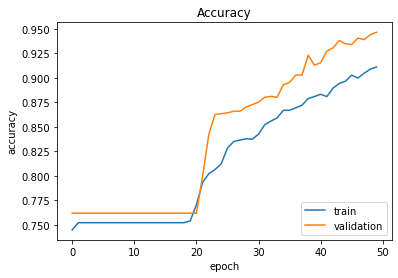

In [64]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

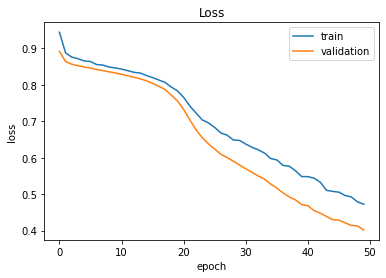

In [65]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
# plt.ylim((-0.1, 1.1))
plt.show()

### Observations:

- Based on the **model.evaluate** I can say that the model is performing well on classifying the data correctly. Talking about **recall**, both shows similar and good outcomes on both training and validation data.
- The accuracies for the both the training and validation data was constant for first 20 epochs and then increased at the same pace (parallel to each other) for the next 30 epochs, reaching to 95% and 93% respectively.
- Also, the model shows an improved performance on loss too. The loss for both the train and validation data keeps decreasing till the 50 epochs simultaneously and stabilizes at the end.

## Deep Learning: Predictions on train, validation and test data

In [66]:
print("******** Training Data ********")
# Make a set of predictions for the training data
y_pred = textcnnmodel.predict(Xcnn_train)
# y_pred has a predict value for each instance in Xcnn_train
print(y_pred.shape)

predict_results=y_pred.argmax(axis=1)

******** Training Data ********
174/174 [==============================] - 1s 4ms/step
(5563, 2)


******** Training Data ********
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1378
           1       0.95      0.98      0.96      4185

    accuracy                           0.94      5563
   macro avg       0.94      0.91      0.92      5563
weighted avg       0.94      0.94      0.94      5563



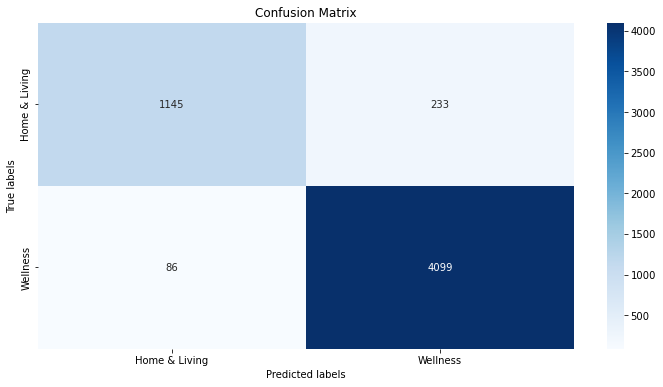

In [67]:
print("******** Training Data ********")

print(metrics.classification_report(y_train_1, predict_results.tolist()))

cm=confusion_matrix(y_train_1, predict_results.tolist())
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

In [68]:
print("******** Validation Data ********")
# Make a set of predictions for the validation data
y_pred = textcnnmodel.predict(Xcnn_valid)
# y_pred has a predict value for each instance in Xcnn_valid
print(y_pred.shape)

predict_results=y_pred.argmax(axis=1)

******** Validation Data ********
38/38 [==============================] - 0s 4ms/step
(1193, 2)


******** Validation Data ********
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       284
           1       0.95      0.98      0.97       909

    accuracy                           0.95      1193
   macro avg       0.94      0.91      0.92      1193
weighted avg       0.95      0.95      0.95      1193



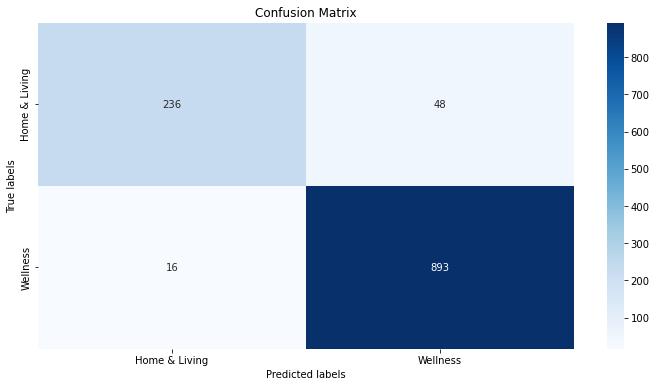

In [69]:
print("******** Validation Data ********")

print(metrics.classification_report(y_valid_1, predict_results.tolist()))

cm=confusion_matrix(y_valid_1, predict_results.tolist())
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

In [70]:
print("******** Test Data ********")
# Make a set of predictions for the test data
y_pred = textcnnmodel.predict(Xcnn_test)
# y_pred has a predict value for each instance in Xcnn_test
print(y_pred.shape)

predict_results=y_pred.argmax(axis=1)

******** Test Data ********
38/38 [==============================] - 0s 4ms/step
(1193, 2)


******** Test Data ********
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       321
           1       0.93      0.97      0.95       872

    accuracy                           0.93      1193
   macro avg       0.92      0.89      0.90      1193
weighted avg       0.93      0.93      0.92      1193



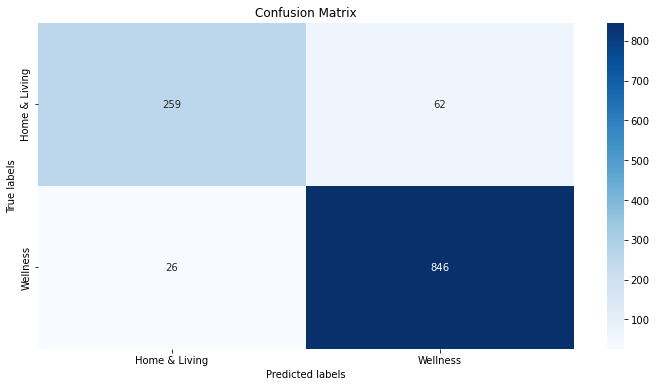

In [71]:
print("******** Test Data ********")

print(metrics.classification_report(y_test_1, predict_results.tolist()))

cm=confusion_matrix(y_test_1, predict_results.tolist())
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Observations:

- The model performed well on all the train, validation and test data.
- In comparison, test data showed better performance than the validation set as misclassified 3 lesser data points than validation data for **Home & Living**. So, **recall** was slightly better is case of test data i.e. 85%.
- Recall for **Wellness** didn't showed any difference for both validation and test data. Also, precision was similar. Therefore, here because of improvement in Recall score the perdictions was better on test results.


<span style="color:red">Step 8</span>

# Data Evaluation: SVC & LR model

I have decided to choose **Confusion Matrix** as my evaluation metrics because of the following reasons:

1. Confusion matrices are not just useful in model evaluation but also model monitoring and model management.
2. General accuracy is often not enough information to allow you to decide on a model’s value.
3. Confusion matrices can help with side-by-side comparisons of different classification methods. You can see not only how accurate one model is over the other, but also see more granularly how a model does in sensitivity or specificity, as those might be more important factors than general accuracy itself. 
4. I will look at two factors mainly, __F1 score__ as it is the most common metrics used on unbalanced classification problems as compared to accuracy. Also, as F1 score is a harmonic mean between precision and recall. It will calculate the weighted average of both precision and recall.
5. Another one, I will be focussing on the **Recall** percentage which will be like my **primary metric** for minority category 0 (Home & Living). I will try to **increase Recall** score by making an effort to **decrease the false negatives** i.e. I will try to achieve this by classifying the documents which were not correctly assigned to the **Home & Living** category. I think these will be good benchmarks as both better precision and recall will lead to a better model. 

### SVC: Performance on training data

SVC ::

Confusion matrix for training data:

               precision    recall  f1-score   support

Home & Living       1.00      0.98      0.99      1378
     Wellness       0.99      1.00      1.00      4185

     accuracy                           0.99      5563
    macro avg       1.00      0.99      0.99      5563
 weighted avg       0.99      0.99      0.99      5563



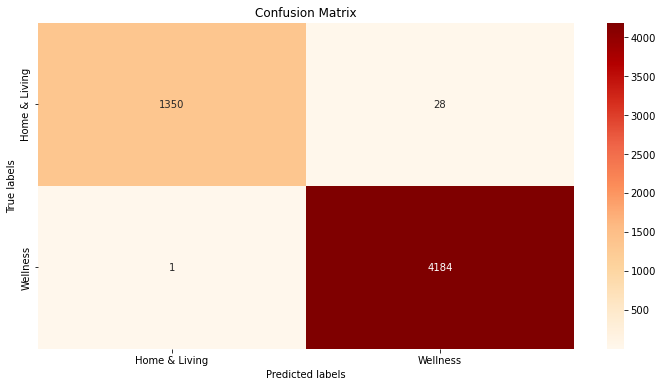

In [72]:
# Changing X and y to evaluate the results of the SVC model on training data:
X_cm = X_train_matrix
y_true_labels = y_train
model = svc_model

# Predicting the y-variable i.e. y_pred based on the fitted model on X_training data
# Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_train = model.predict(X_cm)
print("SVC ::\n")

print("Confusion matrix for training data:\n")
print(metrics.classification_report(y_true_labels, y_pred_train, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_train)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "OrRd"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### SVC: Performance on validation data



SVC ::

Confusion matrix for validation data:

               precision    recall  f1-score   support

Home & Living       0.97      0.92      0.95       284
     Wellness       0.98      0.99      0.98       909

     accuracy                           0.97      1193
    macro avg       0.97      0.96      0.96      1193
 weighted avg       0.97      0.97      0.97      1193



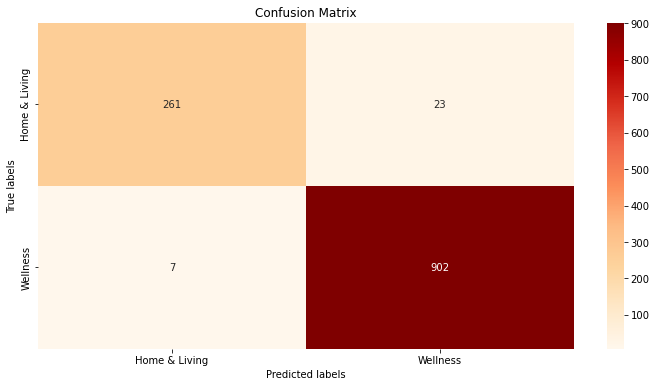

In [73]:
# Changing X and y to evaluate the results of the SVC model on validation data:

X_cm = X_valid_matrix
y_true_labels = y_valid

# Predicting the y-variable i.e. y_pred based on the fitted model on X_valid data
# Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_val = model.predict(X_cm)
print("SVC ::\n")

print("Confusion matrix for validation data:\n")
print(metrics.classification_report(y_true_labels, y_pred_val, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_val)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "OrRd"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Logistic Regression: Performance on training data

Logistic Regression::

Confusion matrix for training data:

               precision    recall  f1-score   support

Home & Living       1.00      0.81      0.90      1378
     Wellness       0.94      1.00      0.97      4185

     accuracy                           0.95      5563
    macro avg       0.97      0.91      0.93      5563
 weighted avg       0.96      0.95      0.95      5563



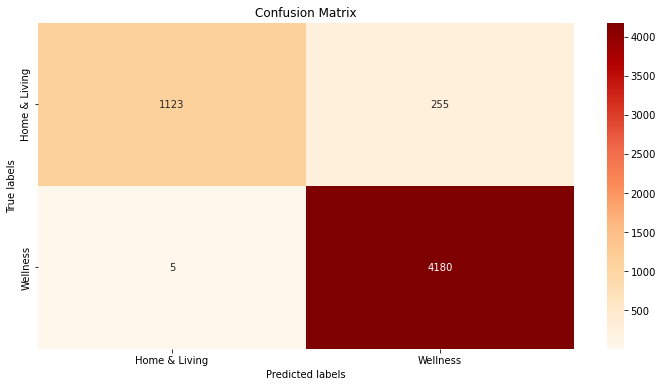

In [74]:
# Changing X and y to evaluate the results of the Logistic Regression model on training data:
X_cm = X_train_matrix
y_true_labels = y_train
model_1 = l_reg

# Predicting the y-variable i.e. y_pred based on the fitted model on X_training data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_train_l = model_1.predict(X_cm)
print("Logistic Regression::\n")
print("Confusion matrix for training data:\n")
print(metrics.classification_report(y_true_labels, y_pred_train_l, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_train_l)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "OrRd"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Logistic Regression: Performance on validation data

Logistic Regression::

Confusion matrix for validation data:

               precision    recall  f1-score   support

Home & Living       0.99      0.82      0.90       284
     Wellness       0.95      1.00      0.97       909

     accuracy                           0.96      1193
    macro avg       0.97      0.91      0.93      1193
 weighted avg       0.96      0.96      0.95      1193



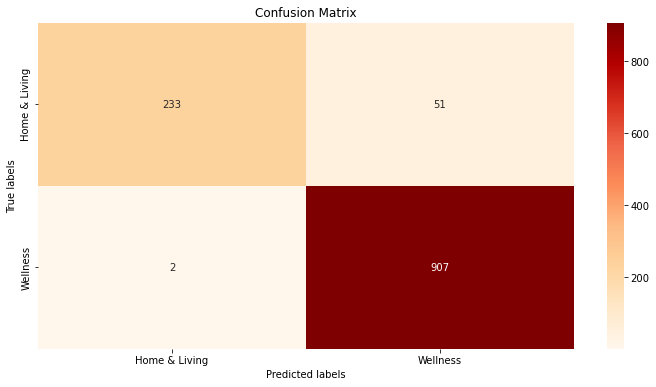

In [75]:
# Changing X and y to evaluate the results of the Logistic Regression model on validation data:
X_cm = X_valid_matrix
y_true_labels = y_valid

# Predicting the y-variable i.e. y_pred based on the fitted model on X_validation data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_val_l = model_1.predict(X_cm)

print("Logistic Regression::\n")
print("Confusion matrix for validation data:\n")
print(metrics.classification_report(y_true_labels, y_pred_val_l, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_val_l)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "OrRd"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

<span style="color:red">Step 9</span>

### Performance Comparison: SVC v/s LR 

- The **Confusion Matrix** for both the models shows pretty good results on the train and validation data considering it an unbalanced dataset. We can also see that the precision is the major contributing factor behind getting a good f1-score. Precision for both the categories in the models is pretty good. However, **recall** performance differs for both the categories. It performs better for majority class "Wellness" as comaperd to minority class "Home & Living".
- We can also see that "SVC" performance is **better** as compared to the "LR" on both the training and validation data. The reason being, SVM tries to finds the “best” margin (distance between the line and the support vectors) that separates the classes and this reduces the risk of error on the data, while logistic regression does not, instead it can have different decision boundaries with different weights that are near the optimal point.
Source: https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16#:~:text=SVM%20tries%20to%20finds%20the,are%20near%20the%20optimal%20point.
- Also, as there is not much difference between the training and validation **accuracies** that means that both the models aren't **overfitting**. It can be due to the presence of regularization parameter in both the models. However, as expected training f1 scores and accuracies are greater than that of validation data.
Source: https://www.quora.com/How-do-we-know-whether-a-model-is-overfitting
- Another thing to notice from the classification report is that the **Recall** score for "Home & Living" category is far more less for "Logistic Regression" model as compared to the "SVC" model. In SVC model, about 28 (Train), 23 (Validation) data points were misclassified as Wellness, however, in LR model the count rose to 255 (Train), 51 (Validation) according to the confusion matrix, which proves the second point.
- Cumulative F1-scores for both the models on both the training and validation data is approximately **1**.

### Error Analysis

### SVC

#### On training set

In [76]:
train_data['category_pred'] = y_pred_train
train_analysis = train_data.loc[(train_data['CategoryId']==0) & (train_data['category_pred']==1)]
#train_analysis.to_csv("err_train_svc.csv")

#### On validation set

In [77]:
valid_data['category_pred'] = y_pred_val
val_analysis = valid_data.loc[(valid_data['CategoryId']==0) & (valid_data['category_pred']==1)]
#val_analysis.to_csv("err_val_svc.csv")

### Logistic Regression

#### On training set

In [78]:
train_data['category_pred'] = y_pred_train_l
train_analysis = train_data.loc[(train_data['CategoryId']==0) & (train_data['category_pred']==1)]
#train_analysis.to_csv("err_train_lr.csv")

#### On validation set

In [79]:
valid_data['category_pred'] = y_pred_val_l
val_analysis = valid_data.loc[(valid_data['CategoryId']==0) & (valid_data['category_pred']==1)]
#val_analysis.to_csv("err_val_lr.csv")

<span style="color:red">Step 10</span>

### Observations

- Almost all the records incorrectly predicted by the SVC model were present in the Logistic Regression error analysis csv file. After studying those records I found that many words mentioned in those sentences like "incandescent","autumn","shipping","nifty" etc. were rare and unique. Therefore, I assume that they were mis-classified because of their negligible count and classified to the majority class i.e. "Wellness" as weighted more.
- Furthermore, records containing popular and common words like "new","make","day","time" etc. were bound to be mis-classified as "Wellness" category because these have much higher count as compared in the "Home&Living" category as it has less records. Therefore, again due to imbalance of data records got misclassified. Refer to Step 3(i) or most common words after pre-processing.
- We can say that both the models have potential to perform better if we reduce the imbalance.

<span style="color:red">Step 11</span>


### First Improvement: In Feature Engineering

I will set **max_df** parameter in TF-IDF vectorizer to 0.8 so that it doesn't consider most popular common words like "new", "make", "day" for both the categories. It will build a vocabulary  that ignore terms that have a document frequency strictly higher than the given threshold i.e. 0.8

Furthermore, I will set **min_df** as 2, which means "ignore terms that appear in less than 2 document" to remove rare frequency words.

**Sublinear tf-scaling** is set to True, to scale down the weight of term algorithm as it is occurring multiple times(maximum tf) in first document.

In [80]:
vectorizer_1 = TfidfVectorizer(max_df=0.8, min_df=2, sublinear_tf=True)

# Vectorizing training and validation dataset
#Fit the vecotrizer on training dataset
vectorizer_1.fit(train_data['description'])

#Transforming training and validation dataset
X_train_matrix_1 = vectorizer_1.transform(train_data['description'])
X_valid_matrix_1 = vectorizer_1.transform(valid_data['description'])

### SVC

In [81]:
svc_model_1 = SVC(kernel="linear", C=1.0, random_state=0)
svc_model_1.fit(X_train_matrix_1, y_train)

SVC(kernel='linear', random_state=0)

#### SVC: Training data performance

SVC ::

Confusion matrix for training data:

               precision    recall  f1-score   support

Home & Living       1.00      0.97      0.98      1378
     Wellness       0.99      1.00      0.99      4185

     accuracy                           0.99      5563
    macro avg       0.99      0.98      0.99      5563
 weighted avg       0.99      0.99      0.99      5563



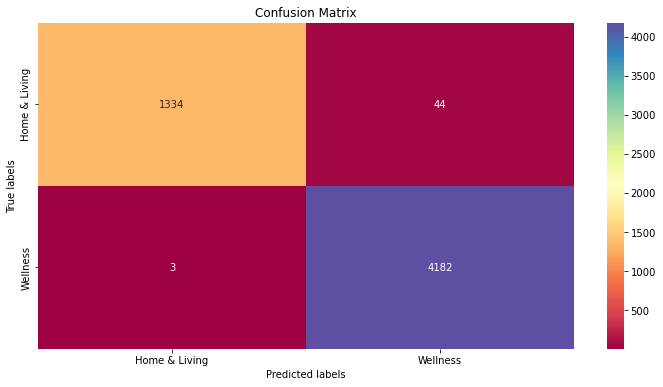

In [82]:
# Changing X and y to evaluate the results of the SVC model on training data:
X_cm = X_train_matrix_1
y_true_labels = y_train
model = svc_model_1

# Predicting the y-variable i.e. y_pred based on the fitted model on X_training data
# Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_train = model.predict(X_cm)
print("SVC ::\n")

print("Confusion matrix for training data:\n")
print(metrics.classification_report(y_true_labels, y_pred_train, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_train)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Spectral'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

#### SVC: Validation data performance

SVC ::

Confusion matrix for validation data:

               precision    recall  f1-score   support

Home & Living       0.97      0.91      0.94       284
     Wellness       0.97      0.99      0.98       909

     accuracy                           0.97      1193
    macro avg       0.97      0.95      0.96      1193
 weighted avg       0.97      0.97      0.97      1193



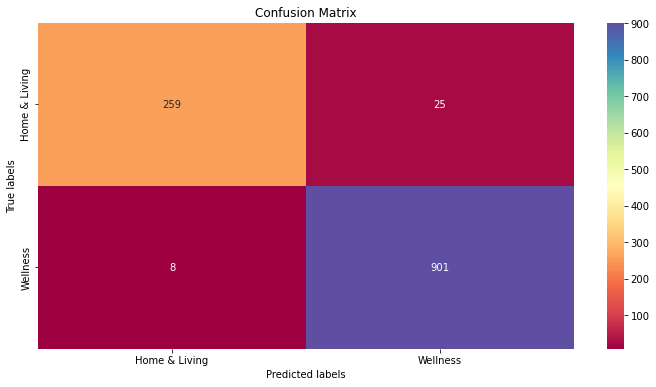

In [83]:
# Changing X and y to evaluate the results of the SVC model on validation data:

X_cm = X_valid_matrix_1
y_true_labels = y_valid
# Predicting the y-variable i.e. y_pred based on the fitted model on X_valid data
# Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_val = model.predict(X_cm)
print("SVC ::\n")

print("Confusion matrix for validation data:\n")
print(metrics.classification_report(y_true_labels, y_pred_val, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_val)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Spectral'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Logistics Regression

In [84]:
l_reg_1 = LogisticRegression(solver='liblinear', random_state=0)
l_reg_1.fit(X_train_matrix_1,y_train)

LogisticRegression(random_state=0, solver='liblinear')

#### Logistic Regression: Training data performance

Logistic Regression::

Confusion matrix for training data:

               precision    recall  f1-score   support

Home & Living       1.00      0.82      0.90      1378
     Wellness       0.95      1.00      0.97      4185

     accuracy                           0.96      5563
    macro avg       0.97      0.91      0.94      5563
 weighted avg       0.96      0.96      0.95      5563



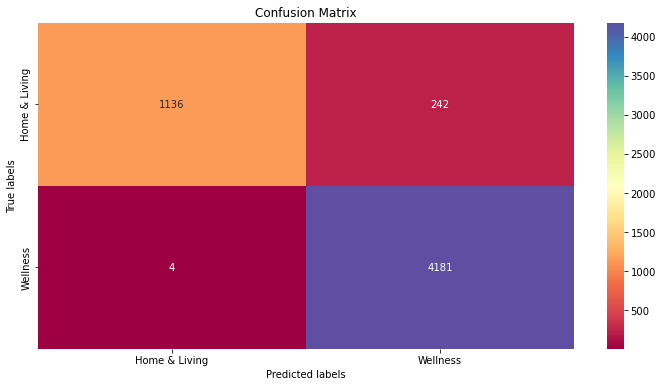

In [85]:
# Changing X and y to evaluate the results of the Logistic Regression model on training data:
X_cm = X_train_matrix_1
y_true_labels = y_train
model_1 = l_reg_1

# Predicting the y-variable i.e. y_pred based on the fitted model on X_training data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_train_l = model_1.predict(X_cm)
print("Logistic Regression::\n")
print("Confusion matrix for training data:\n")
print(metrics.classification_report(y_true_labels, y_pred_train_l, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_train_l)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Spectral'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

#### Logistic Regression: Validation data performance

Logistic Regression::

Confusion matrix for validation data:

               precision    recall  f1-score   support

Home & Living       0.99      0.83      0.90       284
     Wellness       0.95      1.00      0.97       909

     accuracy                           0.96      1193
    macro avg       0.97      0.91      0.94      1193
 weighted avg       0.96      0.96      0.96      1193



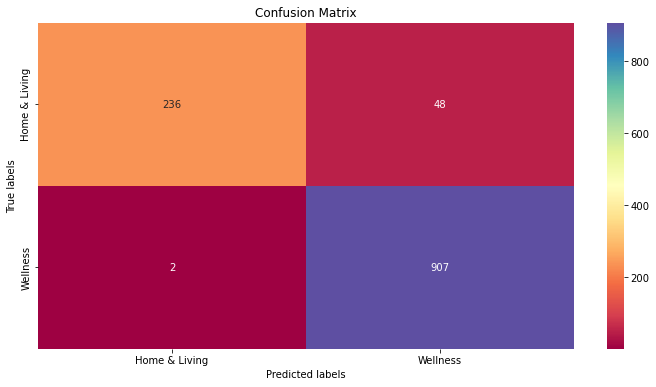

In [86]:
# Changing X and y to evaluate the results of the Logistic Regression model on validation data:
X_cm = X_valid_matrix_1
y_true_labels = y_valid

# Predicting the y-variable i.e. y_pred based on the fitted model on X_validation data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_val_l = model_1.predict(X_cm)

print("Logistic Regression::\n")
print("Confusion matrix for validation data:\n")
print(metrics.classification_report(y_true_labels, y_pred_val_l, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_val_l)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Spectral'); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Observations

- Changing the parameters in the TF-IDF vectorizer helped to increase the **Recall** percentage of "Home & Living " cateogry in the **Logistic Regression** model for both the training and validation datasets. Initially, it was 82% and 83% for train and val respectively however after adding min_df, max_df as parameters it improved to 82% and 83% respectively. Therefore, improving the number of correct predictions by a small margin i.e. decrease in **false negatives** for Home & Living category. 

- Furthermore, the **Recall** percentage for **SVC**'s training and validation data reduced by 1% respectively for the "Home & Living" category respectively. Eariler, it misclassified 23 records and after the parameter change, it increased to 25, while no changes in other predictions related to the Wellness category. Even after a slight difference in recall and precision, model is still providing good f1-score as output.

<span style="color:red">Step 11</span>

### Second Improvement: Changes in the model parameters

### SVC

#### Parameters
- I changed **C** parameter i.e. penality/regularization to **2** to choose a slightly smaller margin so that the model can avoid misclassifying data. I just increased it by 1 because I do not want the model to over-fit. I can further decide a good C value after cross-validation, if SVC comes out to be a better model.

Source: https://stackoverflow.com/questions/12809633/parameter-c-in-svm-standard-to-find-best-parameter
- I added the **class_weight** parameter to encounter the data imbalance issue. By setting it to **balanced**, it basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.
The argument class_weight='balanced' penalizes mistake on the minority class by an amount proportional to how under-represented it is.

Source: https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work

In [87]:
svc_model_1 = SVC(kernel="linear", C=2.0, random_state=0, class_weight='balanced')
svc_model_1.fit(X_train_matrix_1, y_train)

SVC(C=2.0, class_weight='balanced', kernel='linear', random_state=0)

#### Performance on training data

SVC ::

Confusion matrix for training data:

               precision    recall  f1-score   support

Home & Living       1.00      1.00      1.00      1378
     Wellness       1.00      1.00      1.00      4185

     accuracy                           1.00      5563
    macro avg       1.00      1.00      1.00      5563
 weighted avg       1.00      1.00      1.00      5563



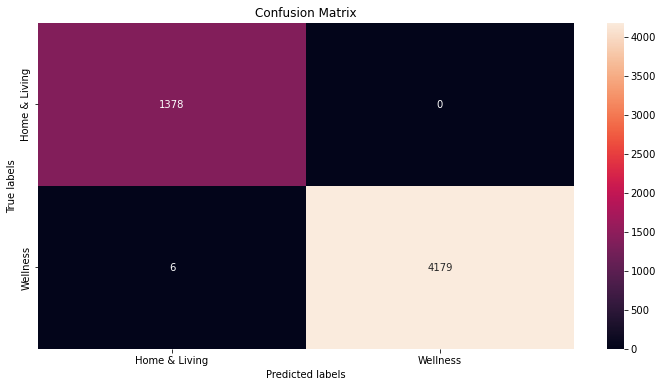

In [88]:
# Changing X and y to evaluate the results of the SVC model on training data:
X_cm = X_train_matrix_1
y_true_labels = y_train
model = svc_model_1

# Predicting the y-variable i.e. y_pred based on the fitted model on X_training data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_train = model.predict(X_cm)
print("SVC ::\n")

print("Confusion matrix for training data:\n")
print(metrics.classification_report(y_true_labels, y_pred_train, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_train)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

#### Performance on validation data

SVC ::

Confusion matrix for validation data:

               precision    recall  f1-score   support

Home & Living       0.94      0.93      0.93       284
     Wellness       0.98      0.98      0.98       909

     accuracy                           0.97      1193
    macro avg       0.96      0.95      0.95      1193
 weighted avg       0.97      0.97      0.97      1193



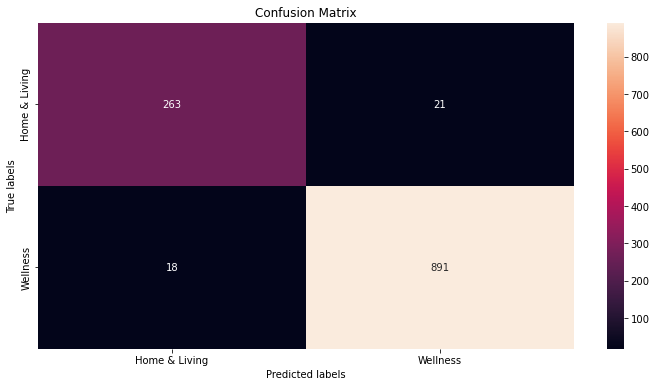

In [89]:
# Changing X and y to evaluate the results of the SVC model on validation data:

X_cm = X_valid_matrix_1
y_true_labels = y_valid
# Predicting the y-variable i.e. y_pred based on the fitted model on X_valid data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_val = model.predict(X_cm)
print("SVC ::\n")

print("Confusion matrix for validation data:\n")
print(metrics.classification_report(y_true_labels, y_pred_val, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_val)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Logistic Regression

#### Parameters:
- I added the **class_weight** parameter to encounter the data imbalance issue. By setting it to **balanced**, it basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.
The argument class_weight='balanced' penalizes mistake on the minority class by an amount proportional to how under-represented it is.

Source: https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work


In [90]:
l_reg_1 = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')
l_reg_1.fit(X_train_matrix_1,y_train)

LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')

#### Performance on training data

Logistic Regression::

Confusion matrix for training data:

               precision    recall  f1-score   support

Home & Living       0.97      0.98      0.97      1378
     Wellness       0.99      0.99      0.99      4185

     accuracy                           0.99      5563
    macro avg       0.98      0.98      0.98      5563
 weighted avg       0.99      0.99      0.99      5563



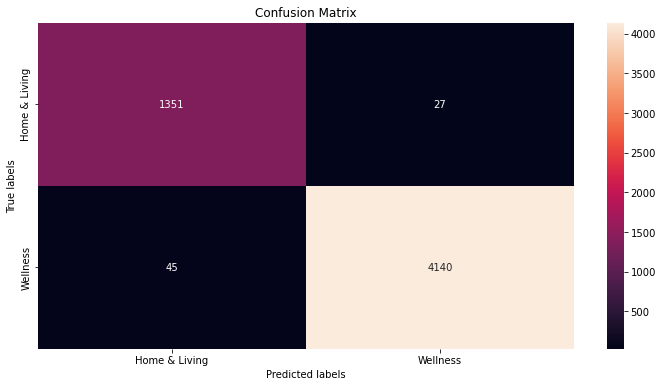

In [91]:
# Changing X and y to evaluate the results of the Logistic Regression model on training data:
X_cm = X_train_matrix_1
y_true_labels = y_train
model_1 = l_reg_1

# Predicting the y-variable i.e. y_pred based on the fitted model on X_training data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_train_l = model_1.predict(X_cm)
print("Logistic Regression::\n")
print("Confusion matrix for training data:\n")
print(metrics.classification_report(y_true_labels, y_pred_train_l, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_train_l)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

#### Performance on validation data

Logistic Regression::

Confusion matrix for validation data:

               precision    recall  f1-score   support

Home & Living       0.94      0.94      0.94       284
     Wellness       0.98      0.98      0.98       909

     accuracy                           0.97      1193
    macro avg       0.96      0.96      0.96      1193
 weighted avg       0.97      0.97      0.97      1193



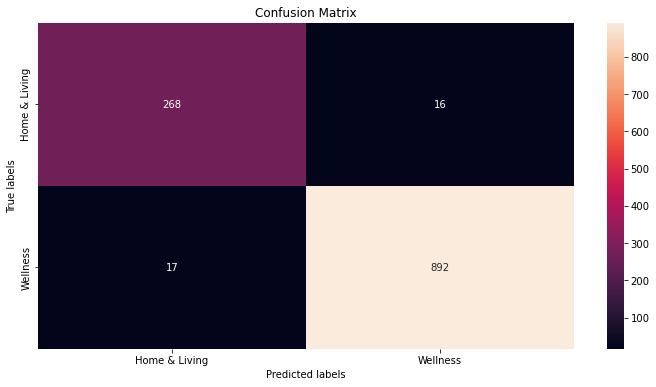

In [92]:
# Changing X and y to evaluate the results of the Logistic Regression model on validation data:
X_cm = X_valid_matrix_1
y_true_labels = y_valid

# Predicting the y-variable i.e. y_pred based on the fitted model on X_validation data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_val_l = model_1.predict(X_cm)

print("Logistic Regression::\n")
print("Confusion matrix for validation data:\n")
print(metrics.classification_report(y_true_labels, y_pred_val_l, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_val_l)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Observations

- Adding the **class weight = 'balanced'** parameter improved the performance greatly as shown above, as well as the **recall percentage increased** for both the models in the classification report. Before this, **SVC** was performing better than Logistic regression model but now they both are showing similar f1 scores (differs by 1% for Home & Living) that means that adding class weight has helped the models in better classifications as compared to before as treats the imbalance. The mis-classification in confusion matrix of "Home and Living" reduced from 25 to 21.
- The **Logistic Regression** model improved more as compared to the SVC model. The **recall** probability score for "Home and Living" category rose to 94% from 83% and also without much compromising the precision value i.e. **false negatives** reduced from 48 to 16.
- I can say that the benchmark was achieved as I was able to get a better performance of the **Confusion Matrix** by increasing the recall score which indeed increase the f1- score for both the models.

### Saving both the models

In [93]:
with open('svc_model.pkl','wb') as f:
    pickle.dump(svc_model_1,f)

In [94]:
with open('lr_model.pkl','wb') as f:
    pickle.dump(l_reg_1,f)

<span style="color:red">Step 12</span>

### Cross Validation on Train+Validation data

I am using K-Folds technique as it's popular, easy to understand, it generally results in a less biased model compare to other methods. As it ensures that every observation from the original dataset has the chance of appearing in training and validation set.
This is one among the best approach if we have a limited input data.

In [95]:
train_val_data = pd.concat([train_data, valid_data])
train_val_data.reset_index(drop=True, inplace=True)

In [96]:
train_val_data.drop('category_pred', axis=1, inplace=True)
train_val_data

,description,CategoryId
0,despite new study expert still warn link footb...,1
1,weekly roundup ebay vintage home find photo al...,0
2,boston named healthiest city america follow ne...,1
3,eyeopening shopping experience alyssa croteau ...,1
4,look inside fantastic first home house tour ro...,0
...,...,...
6751,lowcalorie french fry recipe told could make h...,1
6752,make life transition transition wonderful oppo...,1
6753,author nicholas spark key happiness video matt...,1
6754,home le photo bring good news bargainhunting f...,0


In [97]:
# I am using n_splits as 10 to expect lower prediction error
folder = KFold(n_splits=10)

In [98]:
vectorizer_2 = TfidfVectorizer(max_df=0.8, min_df=2, sublinear_tf=True)

# Vectorizing training and validation dataset
#Fit the vecotrizer on training dataset
vectorizer_2.fit(train_val_data['description'])

#Transforming training and validation dataset
X_train_val_matrix = vectorizer_2.transform(train_val_data['description'])

#### SVC: Cross Validation

In [99]:
svc = SVC(kernel="linear", C=2.0, random_state=0, class_weight='balanced')


In [100]:
results = cross_val_score(svc ,X_train_val_matrix,train_val_data['CategoryId'], cv = folder)# Parameters are, in order - model, X data, labels (y), and the KFold object
results

array([0.96301775, 0.96153846, 0.95857988, 0.93934911, 0.96301775,
       0.96301775, 0.95703704, 0.96444444, 0.97185185, 0.97037037])

In [101]:
output = pd.DataFrame(results, columns=["Accuracy_per_fold"])
output

,Accuracy_per_fold
0,0.963018
1,0.961538
2,0.958580
3,0.939349
4,0.963018
5,0.963018
6,0.957037
7,0.964444
8,0.971852
9,0.970370


In [102]:
av_val = output["Accuracy_per_fold"].mean()*100
print("SVC: The average accuracy across folds is {}%".format(round(av_val,2)))

SVC: The average accuracy across folds is 96.12%


#### Logistic Regression: Cross Validation

In [103]:
l_reg_3 = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')

In [104]:
results_lr = cross_val_score(l_reg_3 ,X_train_val_matrix,train_val_data['CategoryId'], cv = folder)# Parameters are, in order - model, X data, labels (y), and the KFold object
results_lr

array([0.96301775, 0.96005917, 0.95857988, 0.95414201, 0.95857988,
       0.96745562, 0.96148148, 0.96296296, 0.96888889, 0.97333333])

In [105]:
output = pd.DataFrame(results_lr, columns=["Accuracy_per_fold"])
output

,Accuracy_per_fold
0,0.963018
1,0.960059
2,0.958580
3,0.954142
4,0.958580
5,0.967456
6,0.961481
7,0.962963
8,0.968889
9,0.973333


In [106]:
av_val_1 = output["Accuracy_per_fold"].mean()*100
print("Logistic Regression: The average accuracy across folds is {}%".format(round(av_val_1,2)))

Logistic Regression: The average accuracy across folds is 96.29%


<span style="color:red">Step 13</span>

### Observations

After performing cross-validation on both the classifers, I got that logistic regression model is performing slightly better the SVC classifier. One of the fold observation of SVC is predicting 93.9% accuracy while none of the accuracies of Logistic Regression came down more than 2 percent of the maximum predicted accuracy.

Therefore, I will apply the **Logistic Regression** model on test data.

### Loading and processing test data

In [107]:
test_data=pd.read_csv('test.csv')

In [108]:
test_data.drop('Unnamed: 0',axis=1,inplace=True)

In [109]:
#Applying same pre-processing steps on test data
test_data['description'] = test_data['description'].apply(remove_digits)
test_data['description'] = test_data['description'].apply(remove_tags)
test_data['description'] = test_data['description'].apply(special_char)
test_data['description'] = test_data['description'].apply(convert_lower)
test_data['description'] = test_data['description'].apply(remove_stopwords)
test_data['description'] = test_data['description'].apply(lemmatize_word)

In [110]:
X_test=test_data.loc[:,'description']
y_test=test_data.loc[:,'CategoryId']

In [111]:
X_test_matrix = vectorizer_1.transform(X_test)

In [112]:
with open('lr_model.pkl', 'rb') as f:
    log_reg = pickle.load(f)

Logistic Regression ::

Confusion matrix for test data:

               precision    recall  f1-score   support

Home & Living       0.94      0.91      0.93       321
     Wellness       0.97      0.98      0.97       872

     accuracy                           0.96      1193
    macro avg       0.95      0.95      0.95      1193
 weighted avg       0.96      0.96      0.96      1193



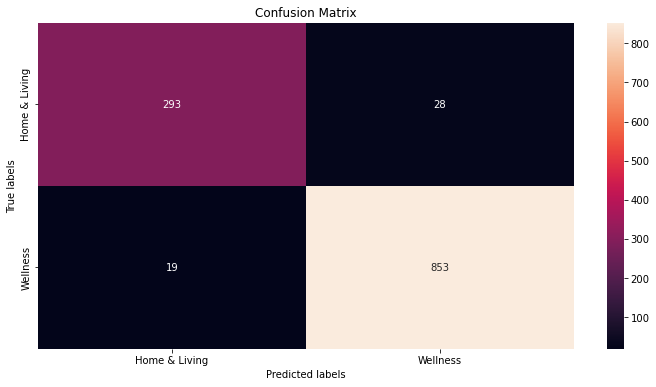

In [113]:
# Changing X and y to evaluate the results of the Logistic Regression model on test data:
X_cm = X_test_matrix
y_true_labels = y_test
model = log_reg

# Predicting the y-variable i.e. y_pred based on the fitted model on X_test_matrix data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_test = model.predict(X_cm)
print("Logistic Regression ::\n")

print("Confusion matrix for test data:\n")
print(metrics.classification_report(y_true_labels, y_pred_test, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_test)
plt.figure(figsize=(12,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Observations: Validation v/s Test Performance

The test data results like precision, f1-scores, accuracy were similar to that of the validation data with some slight variation in the classification i.e. scores on validation data showed slightly better performance than on test data. For instance, if accuracy for validation is predicted 97% then for test it is 96%. And same cases with precision and f1-scores.

While if I consider **false negative** (28 data points aren't predicted as Home & Living even though they are) in the confusion matrix then it's quite different. As you can see above that 16 data points of Home & Living category were mis-classified as Wellness for validation data whereas 28 data points were mis-classified as Wellness for test data. Therefore, model showed **better Recall** score on **validation dataset as compared to test dataset**. However, the cumulative accuracies and f1-scores doesn't vary much.

I think it's because the model's hyperparameters were tuned specifically for the validation dataset. Overall, I will consider them as good results.

<span style="color:red">Step 14</span>

### Re-training LR model on Train+Validation data

In [114]:
l_reg_final = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')
l_reg_final.fit(X_train_val_matrix,train_val_data['CategoryId'])

LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')

In [115]:
X_test_matrix_2 = vectorizer_2.transform(test_data['description'])

Logistic Regression ::

Confusion matrix for test data:

               precision    recall  f1-score   support

Home & Living       0.94      0.92      0.93       321
     Wellness       0.97      0.98      0.97       872

     accuracy                           0.96      1193
    macro avg       0.95      0.95      0.95      1193
 weighted avg       0.96      0.96      0.96      1193



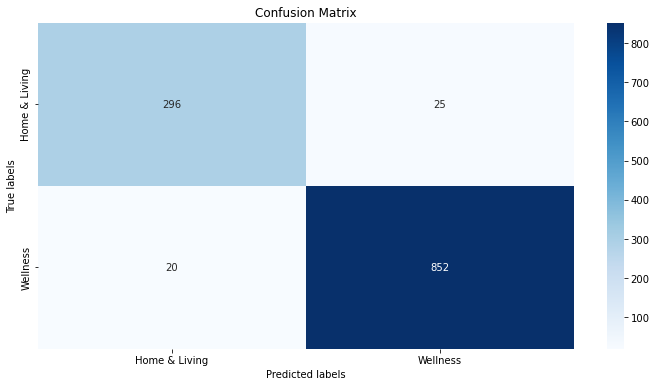

In [116]:
# Changing X and y to evaluate the results of the Logistic Regression model on test data:
X_cm = X_test_matrix_2
y_true_labels = y_test
model = l_reg_final

# Predicting the y-variable i.e. y_pred based on the fitted model on X_test_matrix_2 data
#Plotting and visualizing the true lables and predicted labels in the confusion matrix
y_pred_test = model.predict(X_cm)
print("Logistic Regression ::\n")

print("Confusion matrix for test data:\n")
print(metrics.classification_report(y_true_labels, y_pred_test, target_names=['Home & Living', 'Wellness']))

cm=confusion_matrix(y_true_labels, y_pred_test)
plt.figure(figsize=(12,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Home & Living', 'Wellness']); ax.yaxis.set_ticklabels(['Home & Living', 'Wellness']);

### Observations

I didn't find much difference in the classification report metrics for test data evaluations when tested on model fitted with **train data vs train+validation** data. The only changes which I can notice is that **Recall** score for "Home & Living" has increased when tested against train+validation data. Earlier it was 91% and now it's 92%.

Moreover, in the confusion matrix you can see that after using more data, it is classifying 3 more correct classifications for the minority class (Home&Living) without affecting majority class (Wellness). So, **increased recall** score on Home & Living category.

### Let's predict category of new articles

In [117]:
# Home & Living example: https://www.huffpost.com/entry/how-to-make-home-fancy-hotel_l_62b21aa0e4b06594c1dc6306
# Headline+Short Description

example="How To Make Your Home Feel Like A Fancy Hotel Want to re-create that relaxing vacation environment back home? Follow these expert-backed tips."
example=example.lower()

In [118]:
my_vec=vectorizer_2.transform([example])
text_arr=my_vec.toarray()

In [119]:
#Correctly predicted the category i.e. 0 = Home & Living

l_reg_final.predict(text_arr)

array([0], dtype=int64)

In [120]:
# Wellness category example: https://www.huffpost.com/entry/habits-causing-back-pain_l_62c864ece4b0d740198339e8
# Headline+Short Description

example_2="10 Mindless Habits That May Be Causing You Back Pain If your upper, middle or lower back aches, these behaviors might be the culprit."
example_2=example_2.lower()

In [121]:
my_vec=vectorizer_2.transform([example_2])
text_arr_2=my_vec.toarray()

In [122]:
#Correctly predicted the category i.e. 1 = Wellness

l_reg_final.predict(text_arr_2)

array([1], dtype=int64)